###### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import numpy as np
import matplotlib.pyplot as plt

from mlPlayGround.generative.vae import variationalAutoencoder
from mlPlayGround.model import reshape

###### Load data

In [2]:
class imageOnlyDataset(torch.utils.data.Dataset):
    '''
    Class to extract only the images as do do not need labels to train the VAE
    '''
    def __init__(self, original, index):
        self.__original = original
        self.__index = index

    @property
    def original(self):
        return self.__original

    @property
    def index(self):
        return self.__index

    def __len__(self):
        return len(self.original)

    def __getitem__(self, index):
        return self.original[index][self.index]

In [4]:
thresh = Lambda(lambda x: torch.where(ToTensor()(x) > 0.5, 1.0, 0.0))
onehot = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

trainData = datasets.MNIST(root="../data", train=True, download=True, transform=thresh, target_transform=onehot)
testData = datasets.MNIST(root="../data", train=False, download=True, transform=thresh, target_transform=onehot)

imageData = imageOnlyDataset(trainData, 0)  # remove the labels as we dont need them
print(len(trainData), len(testData), len(imageData))

60000 10000 60000


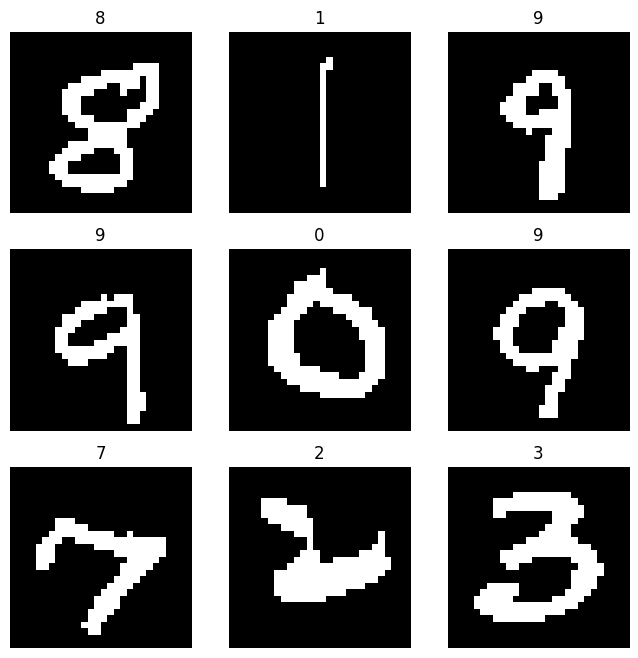

In [7]:
# show some randomly picked numbers
label_map = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sidx = torch.randint(len(trainData), size=(1,)).item()
    img, label = trainData[sidx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[torch.argmax(label, dim=0).item()])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

###### Model

In [9]:
cudaavailable = torch.cuda.is_available()
mpsavailable = torch.backends.mps.is_available()
curr_device = torch.cuda.current_device()

device = torch.device("cuda" if cudaavailable else "mps" if mpsavailable else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {cudaavailable}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda
Device count: 1
Device name: NVIDIA GeForce GTX 970


In [13]:
# build the encoder and decoder networks
hid_dim = 2

encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Flatten(), # reshape([3136]), # 
                        nn.Linear(3136, hid_dim + hid_dim))

decoder = nn.Sequential(nn.Linear(2, 32 * 7 * 7),
                        nn.ReLU(),
                        reshape([32, 7, 7]),
                        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                        nn.Sigmoid())

model = variationalAutoencoder(encoder, decoder, 1.0).to(device)

In [14]:
learning_rate = 1e-3
batch_size = 128
epochs = 25

trainLoader = DataLoader(imageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
model.trainLoop(trainLoader, optimizer, epochs)

Epoch 1
-------------------------------
totalLoss: 206.603043 reconLoss: 200.642029 klLoss: 5.961010[12800/60000]
totalLoss: 187.307114 reconLoss: 181.039062 klLoss: 6.268047[25600/60000]
totalLoss: 174.869003 reconLoss: 168.630676 klLoss: 6.238328[38400/60000]
totalLoss: 174.529526 reconLoss: 168.474182 klLoss: 6.055348[51200/60000]
Epoch 2
-------------------------------
totalLoss: 163.781082 reconLoss: 157.282181 klLoss: 6.498900[12800/60000]
totalLoss: 164.220871 reconLoss: 157.894012 klLoss: 6.326855[25600/60000]
totalLoss: 174.258850 reconLoss: 167.766693 klLoss: 6.492157[38400/60000]
totalLoss: 165.814850 reconLoss: 159.141052 klLoss: 6.673800[51200/60000]
Epoch 3
-------------------------------
totalLoss: 160.552185 reconLoss: 154.020584 klLoss: 6.531605[12800/60000]
totalLoss: 158.497879 reconLoss: 151.728577 klLoss: 6.769306[25600/60000]
totalLoss: 152.967056 reconLoss: 146.113113 klLoss: 6.853945[38400/60000]
totalLoss: 161.622269 reconLoss: 154.975067 klLoss: 6.647195[51200

###### Inference

In [18]:
def plot_latent_space(n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding in the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)[0].cpu().detach()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # set axis ticks corresponding to latent values
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    # axis labels
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

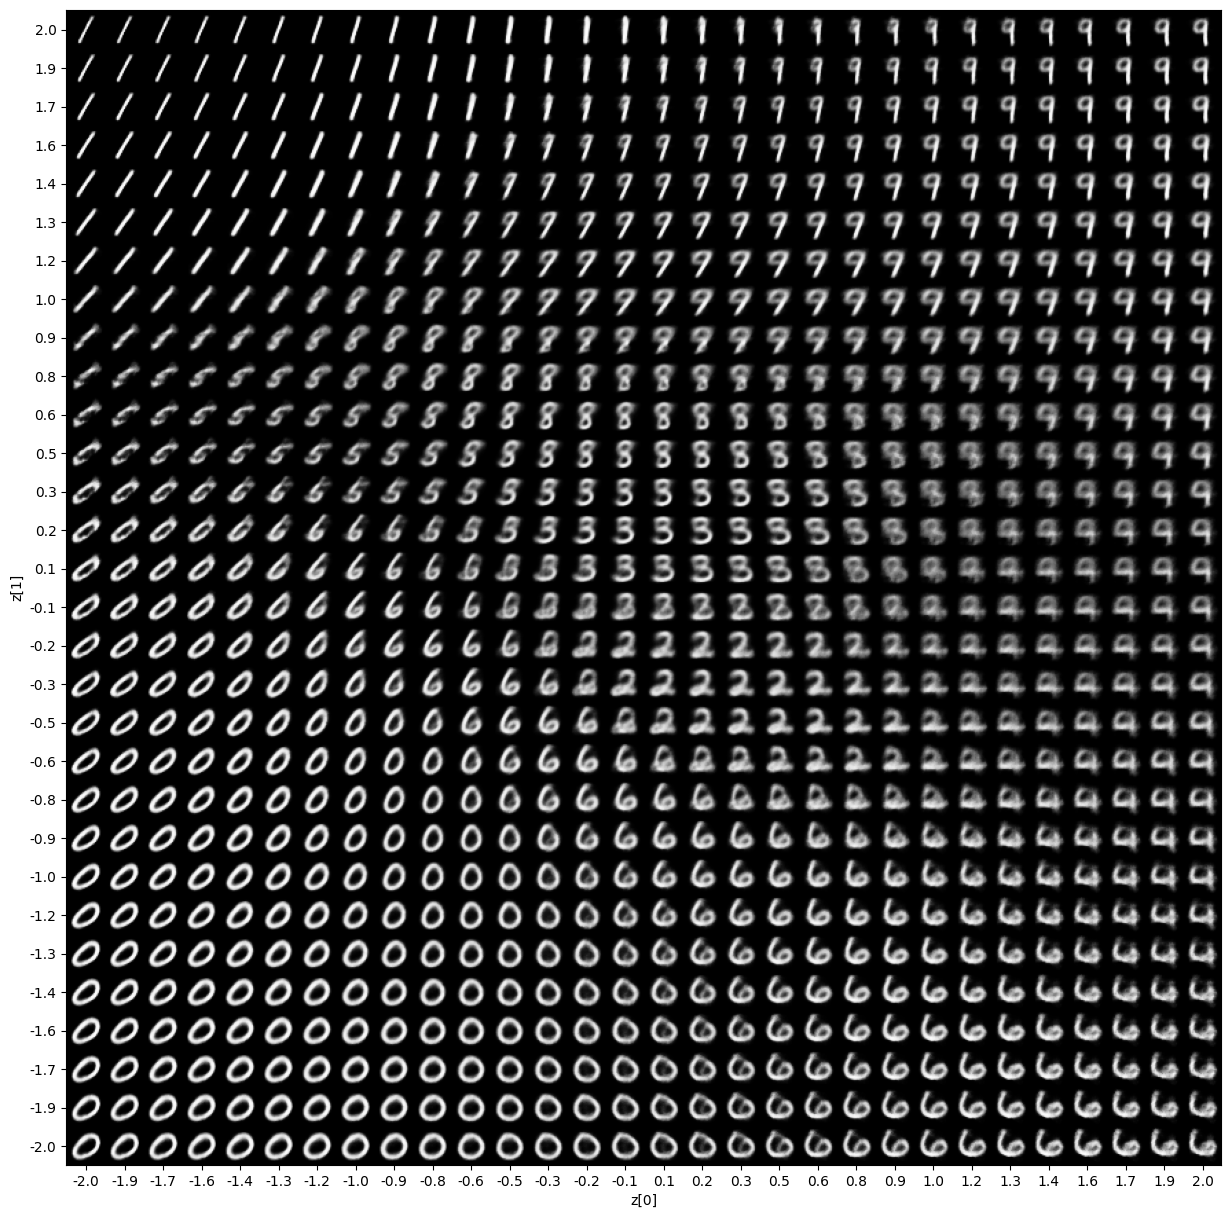

In [19]:
plot_latent_space(scale=2.0, n=30)